# 資料預處理

In [1]:
import os
os.chdir("C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\Code")
import sys
from Get_file import Get_file   # return dirpath, dirnames, filenames
from FFT import FFT
import pyedflib
import numpy as np
import datetime
from scipy.signal import butter, lfilter
from scipy.signal import freqz
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

%matplotlib inline

data_path = "C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\database"  # EEG Data direction
BandPassICAFigureSavingDirection = "C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\Code\\Fig"

# Setting parameters
Sample_frequency = 128
DEBUG = True
label_size = 40
LowerFreqCut = 1
HigherFreqCut = 35
BandPassOrder = 3
channel_we_use = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]   # 0~39 共40, 14 channels we use
SAVE_FIG = False


### 讀取檔案

In [2]:
#Four Lables
normal_label = []   # 0
scare_label = []    # 1
touch_label = []    # 2
laugh_label = []    # 3

#Four Signal
normal_signal = []
scare_signal = []
touch_signal = []
laugh_signal = []

signal = []
labels = []

_,data_files,_ = Get_file(data_path)
if data_files == []:
    raise("Not found any files ! check your data_path")
else:
    print('Get data from database ...')
    for data in data_files:
        _,_,file_names = Get_file(data_path+'\\'+data)
        for fn in file_names:
            if fn.split('.')[1] == 'edf':
                fedf = pyedflib.EdfReader(data_path+'\\'+data+'\\'+fn)
                n = fedf.signals_in_file
                signal_labels = np.asarray(fedf.getSignalLabels())
                sigbufs = np.zeros((n, fedf.getNSamples()[0]))
                for i in np.arange(n):
                    sigbufs[i, :] = fedf.readSignal(i)

                if 'normal' in fn:
                    normal_label.append(0)
                    normal_signal.append(sigbufs)
                elif 'scare' in fn:
                    scare_label.append(1)
                    scare_signal.append(sigbufs)
                elif 'touch' in fn:
                    touch_label.append(2)
                    touch_signal.append(sigbufs)
                elif 'laugh' in fn:
                    laugh_label.append(3)
                    laugh_signal.append(sigbufs)
                    
                if DEBUG:
                    print(sigbufs.shape)

''' Labels --> 40 channels
['COUNTER' 'INTERPOLATED' 'AF3' 'F7' 'F3' 'FC5' 'T7' 'P7' 'O1' 'O2' 'P8'
 'T8' 'FC6' 'F4' 'F8' 'AF4' 'RAW_CQ' 'GYROX' 'GYROY' 'MARKER'
 'MARKER_HARDWARE' 'SYNC' 'TIME_STAMP_s' 'TIME_STAMP_ms' 'CQ_AF3' 'CQ_F7'
 'CQ_F3' 'CQ_FC5' 'CQ_T7' 'CQ_P7' 'CQ_O1' 'CQ_O2' 'CQ_P8' 'CQ_T8' 'CQ_FC6'
 'CQ_F4' 'CQ_F8' 'CQ_AF4' 'CQ_CMS' 'CQ_DRL']
'''

print('Okay')
if DEBUG:
    print('normal signal length : ', len(normal_signal))
    print('scare signal length : ', len(scare_signal))
    print('touch signal length : ', len(touch_signal))
    print('laugh signal length : ', len(laugh_signal))


Get data from database ...
(40, 38400)
(40, 105344)
(40, 38400)
(40, 105344)
(40, 179328)
(40, 309248)
(40, 38400)
(40, 179328)
(40, 309760)
(40, 38400)
(40, 105728)
(40, 158976)
(40, 58112)
(40, 50944)
(40, 33152)
(40, 3968)
(40, 38400)
(40, 105344)
(40, 178944)
(40, 308992)
(40, 38400)
(40, 105728)
(40, 179840)
(40, 237312)
(40, 38400)
(40, 105600)
(40, 179584)
(40, 38400)
(40, 178944)
(40, 308864)
(40, 38400)
(40, 105344)
(40, 179072)
(40, 83328)
(40, 117632)
(40, 107392)
(40, 38400)
(40, 308992)
(40, 38400)
(40, 179072)
(40, 105344)
(40, 308736)
(40, 38400)
(40, 313472)
(40, 38400)
(40, 105344)
(40, 38400)
(40, 105344)
(40, 38528)
(40, 179200)
(40, 308736)
(40, 38400)
(40, 179328)
(40, 38400)
(40, 105344)
Okay
normal signal length :  17
scare signal length :  11
touch signal length :  10
laugh signal length :  17


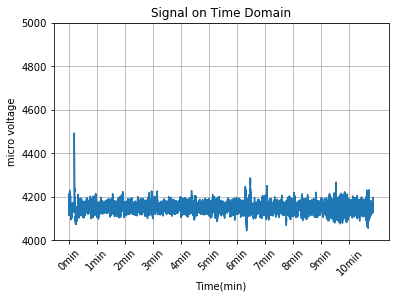

In [3]:
# Plot Raw Data on Time domain -- Function
def PlotDataOnTimeDomain(RawData, SamplingFrequency, LowerYLim=4000, HigherYLim=5000, title=None):
    SamplesPerMinute = Sample_frequency*60   # Unit : samples/ minute
    DataLength = RawData.shape[0]
    ConsumingTime = DataLength/SamplesPerMinute   # Unit : minites
    XTicksMinsList = []
    XTicksSamplesList = []
    for i in range((int(ConsumingTime)+1)):
        XTicksMinsList.append(str((i))+'min')
        XTicksSamplesList.append(i*SamplesPerMinute)
    PlotXAxis = np.linspace(0, DataLength, DataLength)
    plt.plot(PlotXAxis, RawData)
    plt.xticks(XTicksSamplesList, XTicksMinsList, rotation=45)    # format the ticks
    if title is None:
        plt.title('Signal on Time Domain')
    else:
        plt.title(title)
    plt.ylim(LowerYLim, HigherYLim)
    plt.ylabel('micro voltage')
    plt.xlabel('Time(min)')
    plt.grid(True)
    plt.show()

# Example:
PlotDataOnTimeDomain(laugh_signal[10][13], 128)

### Define Band Pass Filter to Make the Data Freqency between 1 Hz to 35 Hz

In [4]:
# Band pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def BandPassFilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Lowpass filter
def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = True)
    return b, a

def butter_lowpass_filter(data, cutOff, fs, order=4):
    b, a = butter_lowpass(cutOff, fs, order=order)
    y = lfilter(b, a, data)
    return y
# Example:
BandPassData = BandPassFilter(laugh_signal[15][3], LowerFreqCut, HigherFreqCut, fs=Sample_frequency, order=BandPassOrder)

### Define ICA (Independent Component Analyze) to find the main featues

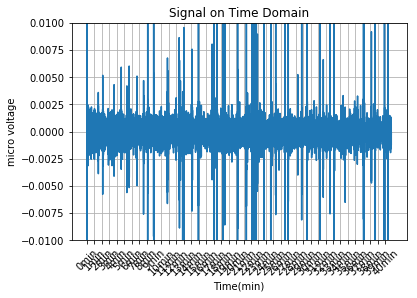

In [5]:
EEGICAModel = FastICA(n_components=1)
ICAData = EEGICAModel.fit_transform(BandPassData.reshape(-1,1))
PlotDataOnTimeDomain(ICAData, 128, -0.01, 0.01)

### Ready to Convert Raw Data to ICA, BandPass

In [6]:
# Normal Data Convert
ICANormalSignalList = []   # New Noral Signal Data
EEGICAModel = FastICA(n_components=1)  # ICA Model initialize
ch_num = 1 

if os.getcwd() != BandPassICAFigureSavingDirection:
    os.chdir(BandPassICAFigureSavingDirection)
_,files,_ = Get_file(BandPassICAFigureSavingDirection)
if 'ICAFig' in files:
    os.chdir('ICAFig')
    pass
else:
    os.mkdir('ICAFig')
    os.chdir('ICAFig')

for i in range(len(normal_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            BandPassData = BandPassFilter(normal_signal[i][ch], LowerFreqCut, HigherFreqCut, fs=Sample_frequency, order=BandPassOrder)
            ICAData = EEGICAModel.fit_transform(BandPassData.reshape(-1,1))
            ICANormalSignalList.append(ICAData)
            
            if SAVE_FIG:
                fig = plt.gcf()   # Get Current Figure, 不加這行，save figire 時會存成白色
                PlotDataOnTimeDomain(ICAData, 128, -0.02, 0.02, title='Normal,num:%d ' % (i+1) + 'ch:%d' % ch_num)

                # Save the Figure
                FigName = 'Normal_%d' % (i+1) + '_%d' % ch_num + '.png'
                fig.savefig(FigName)
            
            ch_num += 1
    ch_num = 1

In [7]:
# Scare Data Convert
ICAScareSignalList = []   # New Noral Signal Data
EEGICAModel = FastICA(n_components=1)  # ICA Model initialize
ch_num = 1 

if os.getcwd() != BandPassICAFigureSavingDirection:
    os.chdir(BandPassICAFigureSavingDirection)
_,files,_ = Get_file(BandPassICAFigureSavingDirection)
if 'ICAFig' in files:
    os.chdir('ICAFig')
    pass
else:
    os.mkdir('ICAFig')
    os.chdir('ICAFig')

for i in range(len(scare_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            BandPassData = BandPassFilter(scare_signal[i][ch], LowerFreqCut, HigherFreqCut, fs=Sample_frequency, order=BandPassOrder)
            ICAData = EEGICAModel.fit_transform(BandPassData.reshape(-1,1))
            ICAScareSignalList.append(ICAData)
            
            if SAVE_FIG:
                fig = plt.gcf()   # Get Current Figure, 不加這行，save figire 時會存成白色
                PlotDataOnTimeDomain(ICAData, 128, -0.02, 0.02, title='Scare,num:%d ' % (i+1) + 'ch:%d' % ch_num)

                # Save the Figure
                FigName = 'Scare_%d' % (i+1) + '_%d' % ch_num + '.png'
                fig.savefig(FigName)

            ch_num += 1
    ch_num = 1

In [8]:
# Touch Data Convert
ICATouchSignalList = []   # New Noral Signal Data
EEGICAModel = FastICA(n_components=1)  # ICA Model initialize
ch_num = 1 

if os.getcwd() != BandPassICAFigureSavingDirection:
    os.chdir(BandPassICAFigureSavingDirection)
_,files,_ = Get_file(BandPassICAFigureSavingDirection)
if 'ICAFig' in files:
    os.chdir('ICAFig')
    pass
else:
    os.mkdir('ICAFig')
    os.chdir('ICAFig')

for i in range(len(touch_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            BandPassData = BandPassFilter(touch_signal[i][ch], LowerFreqCut, HigherFreqCut, fs=Sample_frequency, order=BandPassOrder)
            ICAData = EEGICAModel.fit_transform(BandPassData.reshape(-1,1))
            ICATouchSignalList.append(ICAData)
            
            if SAVE_FIG:
                fig = plt.gcf()   # Get Current Figure, 不加這行，save figire 時會存成白色
                PlotDataOnTimeDomain(ICAData, 128, -0.02, 0.02, title='Touch,num:%d ' % (i+1) + 'ch:%d' % ch_num)

                # Save the Figure
                FigName = 'Touch_%d' % (i+1) + '_%d' % ch_num + '.png'
                fig.savefig(FigName)

            ch_num += 1
    ch_num = 1

In [9]:
# Laugh Data Convert
ICALaughSignalList = []   # New Noral Signal Data
EEGICAModel = FastICA(n_components=1)  # ICA Model initialize
ch_num = 1 

if os.getcwd() != BandPassICAFigureSavingDirection:
    os.chdir(BandPassICAFigureSavingDirection)
_,files,_ = Get_file(BandPassICAFigureSavingDirection)
if 'ICAFig' in files:
    os.chdir('ICAFig')
    pass
else:
    os.mkdir('ICAFig')
    os.chdir('ICAFig')

for i in range(len(laugh_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            BandPassData = BandPassFilter(laugh_signal[i][ch], LowerFreqCut, HigherFreqCut, fs=Sample_frequency, order=BandPassOrder)
            ICAData = EEGICAModel.fit_transform(BandPassData.reshape(-1,1))
            ICALaughSignalList.append(ICAData)
            
            if SAVE_FIG:
                fig = plt.gcf()   # Get Current Figure, 不加這行，save figire 時會存成白色
                PlotDataOnTimeDomain(ICAData, 128, -0.02, 0.02, title='Laugh,num:%d ' % (i+1) + 'ch:%d' % ch_num)

                # Save the Figure
                FigName = 'Laugh_%d' % (i+1) + '_%d' % ch_num + '.png'
                fig.savefig(FigName)
            
            ch_num += 1
    ch_num = 1

### Using FFT to Transfer time domain to frequency domain

In [10]:
# Plot Data on Frequency domain -- Function
def PlotDataOnFreqDomain(FFTData, SamplingFrequency, LowerFreq=8, HigherFreq=30, title=None):
    PlotFreq = np.linspace(LowerFreq, HigherFreq, TimeDomainData.shape[0])
    plt.plot(PlotFreq, FFTData)
    print('efe')
    if title is None:
        plt.title('Frequency Domain Plot')
    else:
        plt.title(title)
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('micro volt (mV)')
    plt.grid(True)
    plt.show()

for i in range(len(ICAScareSignalList)):
    FreqList, FFTData = FFT(ICANormalSignalList[i], Sample_frequency, ICAScareSignalList[i].shape[0])
    
def SignalListTransToFFTList(SignalList, SAVE_FIG=False):   # After BandPass, ICA algorithm
    ch_num = 1
    FFTSignalList = []
    for i in range(len(SignalList)):
        FreqList, FFTData = FFT(SignalList[i], Sample_frequency, SignalList[i].shape[0])
        
        #if SAVE_FIG:
        fig = plt.gcf()   # Get Current Figure, 不加這行，save figire 時會存成白色
        PlotDataOnFreqDomain(FFTData, LowerFreq=LowerFreqCut, HigherFreq=HigherFreqCut,
                            title='FNormal_%d'%ch_num + '_%d'%i)
        
        FFTDataFreqWeWant = (FreqList>=8)
        NewFFTData = FFTData*FFTDataFreqWeWant
        FFTDataFreqWeWant = (FreqList<=30)
        NewFFTData = NewFFTData*FFTDataFreqWeWant
        DeleteZeroValuePos = np.where(NewFFTData==0)
        NewFFTData = np.delete(NewFFTData, DeleteZeroValuePos)
        FFTSignalList.append(NewFFTData)
    ch_num += 1
    return FFTSignalList
    
FFTNormalList = SignalListTransToFFTList(ICAScareSignalList, SAVE_FIG=True)

MemoryError: 

In [12]:
size = ICANormalSignalList[0].shape[0]
print(size)
FFT(ICANormalSignalList[0], Sample_frequency, size)


38400


MemoryError: 

In [ ]:
if DEBUG:
    print('normal size (alpha, beta) : ', normal_alpha.shape, normal_beta.shape)
    print('scare size (alpha, beta)  : ', scare_alpha.shape, scare_beta.shape)
    print('touch size (alpha, beta)  : ', touch_alpha.shape, touch_beta.shape)
    print('laugh size (alpha, beta)  : ', laugh_alpha.shape, laugh_beta.shape)

In [ ]:
# create the target
normal_target = np.ones([normal_alpha.shape[2]]) * 1
scare_target = np.ones([scare_alpha.shape[2]]) * 2
touch_target = np.ones([touch_alpha.shape[2]]) * 3
laugh_target = np.ones([laugh_alpha.shape[2]]) * 4

In [ ]:
X = 0
y = 0
for ch in range(len(channel_we_use)):
    X1 = np.vstack((normal_alpha[:,ch,:].reshape([17,64]),
                         scare_alpha[:,ch,:].reshape([11,64]),
                        touch_alpha[:,ch,:].reshape([10,64]),
                        laugh_alpha[:,ch,:].reshape([17,64])))
    X2 = np.vstack((normal_beta[:,ch,:].reshape([17,64]),
                         scare_beta[:,ch,:].reshape([11,64]),
                        touch_beta[:,ch,:].reshape([10,64]),
                        laugh_beta[:,ch,:].reshape([17,64])))
    X_all = np.hstack((X1,X2))
    y_all = np.hstack((normal_target,
                   scare_target,
                   touch_target,
                   laugh_target)).reshape(-1)
    try:
        X = np.vstack((X,X_all))
        y = np.hstack((y,y_all))
    except Exception as e:
        X = X_all
        y = y_all
        print(e)
    if DEBUG:
        if i > 0:
            print(X.shape, X_all.shape)
            print(y.shape, y_all.shape)

In [ ]:
if DEBUG:
    print(X.shape)
    print(y.shape)

In [ ]:
# from Danny_ML_CLF import Danny_ML_CLF
# clf = Danny_ML_CLF()
# train_X, test_X, train_y, test_y = clf.Split_data(X, y, test_size=0.3, Standard=True)
# clf.Fit_value(train_X, train_y)
# clf.Train()
# clf.Report(test_X, test_y, [1,2,3,4], show_cm=False)
# clf.Report2txt('EEG_Report.txt')
# print('Report Okay !\n\n')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_y = y[:,np.newaxis]
one_hot = OneHotEncoder()
one_hot.fit(one_hot_y)
one_hot_y = one_hot.transform(one_hot_y).toarray()
print(one_hot_y.shape)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, one_hot_y, test_size=0.3)
def next_batch(num, data, labels):

    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]
    labels_shuffle = labels[idx]
    #labels_shuffle = np.asarray(labels_shuffle.values.reshape(len(labels_shuffle), 1))

    return data_shuffle, labels_shuffle

In [ ]:
tf_X = tf.placeholder(tf.float32, [None, 128])
tf_y = tf.placeholder(tf.float32, [None, 4])

In [ ]:
# Neural Network Design
layer1 = tf.layers.dense(tf_X, 500, activation=tf.nn.relu)
hidden1 = tf.layers.dense(layer1, 200, activation=tf.nn.relu)
dropout1 = tf.layers.dropout(hidden1, rate=0.4)
hidden2 = tf.layers.dense(dropout1, 200, activation=tf.nn.relu)
pred = tf.layers.dense(hidden2, 4, activation=tf.nn.softmax)

In [ ]:
# Define the loss function and optimizer
# Calculate Loss (for both TRAIN and EVAL modes)
loss_func = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=pred)
train = tf.train.AdamOptimizer(0.01).minimize(loss_func)

In [ ]:
# Calculate the accuracy
accuracy = tf.metrics.accuracy(labels=tf.argmax(tf_y, axis=1),
                               predictions=tf.argmax(pred, axis=1))[1]

In [ ]:
sess = tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)     # initialize var in graph
losses = []
for i in range(3000):
    b_x, b_y = next_batch(20, train_X, train_y)
    feed_dict = feed_dict={tf_X:train_X, tf_y:train_y}
    sess.run(train, feed_dict=feed_dict)
    losses.append(sess.run(loss_func, feed_dict=feed_dict))
    if i%50 == 0:
        print(losses[-1])
    
def plot_loss(loss_data):
    loss_size = len(losses)
    loss_x = np.linspace(1,loss_size,loss_size)
    plt.plot(loss_x, loss_data)
    plt.grid(True)
    plt.show()
    
plot_loss(losses)